---
layout: page
title: Inflation
---

In [288]:
""" import library and package dependencies """
import sys
sys.path.insert(0, '../src')
import os
from collections import namedtuple

import pandas as pd
from numpy import quantile
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from IPython.display import display, Markdown

from data_loader import load_data, get_last_publish_date

The Consumer Price Index that the Reserve Bank of Australia use to index inflation is published quarterly, one month after the end of each quarter.

In [289]:
""" Load data 
RBA Inflation Rate (Consumer Price Index) is released quarterly, 
and the monthly CPI 'indicator' that includes 2/3rds of the CPI basket is released monthly.
Q3 2023 was published on last thursday of month Thu 26 Oct 2023. Q4 should be expected Thu 25 Jan 2024 but not published on Thu 25 or 26 (public holiday) 27 Sat.
"""
# RBA quarterly inflation rates from 1922
# Rates are published in the month after the quarter ends.
# E.g. the rate for 2024Q1 Jan to March is published end of April 2024.
publish_date = get_last_publish_date()
publish_date_days_ago = (pd.Timestamp.now() - publish_date).days

csv_url = 'https://www.rba.gov.au/statistics/tables/csv/g1-data.csv'
local_file = '../data/g1-data.csv'
max_age_days = publish_date_days_ago

# First 10 rows are descriptive header rows
skip_rows = 10

df_inflation = load_data(csv_url, local_file, max_age_days, skip_rows)

In [290]:
""" Data Transformation """
# GCPIAGYP = Consumer Price Index: All Groups, Percentage change from corresponding quarter of previous year
data_column = 'GCPIAGYP'

# Series ID dates are in the format 'Jan-1959' %b-%Y
df_inflation['Date'] = df_inflation['Series ID'].apply(lambda d: pd.to_datetime(d, format='%b-%Y') + pd.offsets.MonthEnd(1))
df_inflation.set_index('Date', inplace=True)

last_index = df_inflation[data_column].last_valid_index()
# only include rows up to the last_index (drop the NaN rows at end of file)
df_inflation = df_inflation.loc[:last_index]

In [291]:
""" Chart variables """
start_year = 1960
chart_title = 'AU Consumer Price Index Inflation Rate as at ' + str(pd.Period(str(last_index), freq='Q'))
chart_source = 'Source: www.rba.gov.au/statistics/tables G1:GCPIAGYP'
y_label = 'Inflation Rate %'
y_ticks = 2
top_limit = 18
bottom_limit = -2
left_limit = pd.to_datetime(f'{start_year}-01-01')
right_limit = pd.to_datetime('2025-01-01')
tick_years = 5
legend_location='best'

Inflation rocketed through the roof in the 1970s peaking at 18% in 1975. 

Inflation remained highly volatile but eventually stabilized through the 1990s and has been trending slightly down until the sharp rise in 2021.

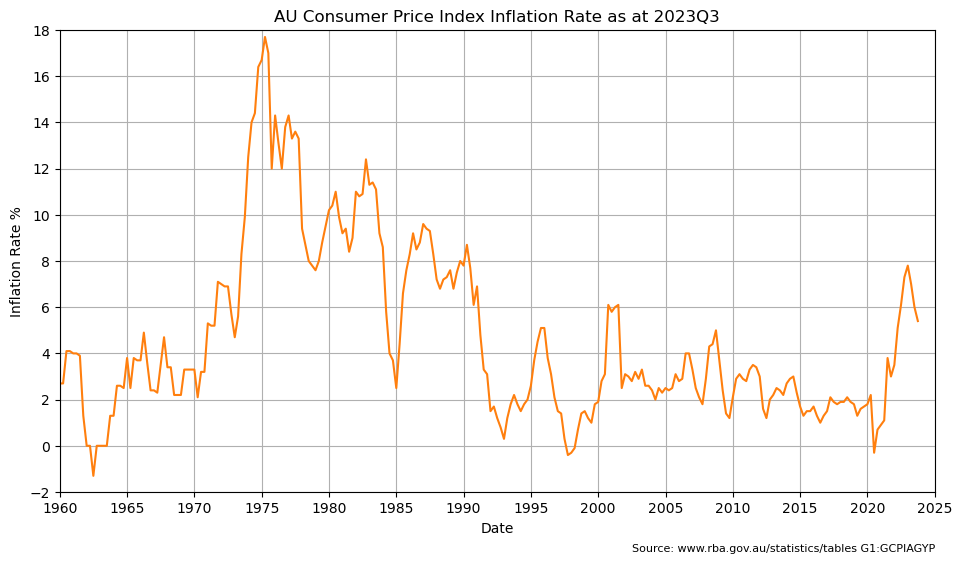

In [292]:
# Basic chart
colors = list(plt.rcParams['axes.prop_cycle'])

plt.figure(figsize=(10, 6))
plt.plot(df_inflation.index, df_inflation[data_column], color=colors[1]['color'])
plt.xlabel('Date')
plt.ylabel(y_label)
plt.title(chart_title)
plt.figtext(1, 0.01, chart_source, ha="right", fontsize=8)
plt.subplots_adjust(right=1)  # Reset right boundary of the subplots after adding figtext


plt.ylim(bottom=bottom_limit, top=top_limit) 
plt.xlim(left=left_limit, right=right_limit)
ax = plt.gca()  # Get the current Axes instance
ax.xaxis.set_major_locator(mdates.YearLocator(tick_years))  # Set major ticks every x years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format major ticks as years
ax.yaxis.set_major_locator(ticker.MultipleLocator(y_ticks)) 

plt.grid(True)
plt.show()

In [293]:
""" Calculate median 50th and lower, upper percentiles over multiple years """
periods_per_year = 4
multi_year = 10
multi_year_extended = 3

# Define the percentiles and window sizes
Percentiles = namedtuple('Percentiles', ['lower', 'median', 'upper'])
percentiles = Percentiles(25, 50, 75)

window_periods = [
    periods_per_year,
    periods_per_year * multi_year,
    periods_per_year * multi_year * multi_year_extended
]

def add_percentiles(df, column, window, prefix):
    """Calculate and add percentiles to the DataFrame for a given window size."""
    for percentile_name, percentile in zip(percentiles._fields, percentiles):
        df[f'{prefix}_{percentile_name}'] = df[column].rolling(window=window).quantile(percentile/100)

# Calculate and add the percentiles for each window size
for window in window_periods:
    years = window // periods_per_year
    name = f'rolling_{years}_years'
    add_percentiles(df_inflation, data_column, window, name)


In [294]:
""" Create a markdown data table of the multi year percentiles"""

# Create the header rows of the table
table = "| years |" + " | ".join(f'{str(percentile)}' for percentile in percentiles) + " |\n"
table += "|---:" * (len(Percentiles._fields) +1) + "|\n"

# Add the percentile values for each window period
for window in window_periods:
    years = window // periods_per_year
    name = f'rolling_{years}_years'
    table += f"| {years} | " + " | ".join("{:,.2f}".format(df_inflation[f'{name}_{percentile_name}'].iloc[-1]) for percentile_name in Percentiles._fields) + " |\n"

In [295]:
display(Markdown(f"""
Calculating the {percentiles[0]}th and {percentiles[2]}th percentile over a {multi_year} year time horizon helps visualize the {Percentiles._fields[0]} and {Percentiles._fields[2]} long term trends.

Over the last {multi_year} years the {Percentiles._fields[1]} ({percentiles[1]}th percetile) change is { "{:,.2f}".format(df_inflation[f'rolling_{multi_year}_years_{Percentiles._fields[1]}'].iloc[-1])  }%.

Over the last {multi_year * multi_year_extended} years the {Percentiles._fields[1]} ({percentiles[1]}th percetile) change is { "{:,.2f}".format(df_inflation[f'rolling_{multi_year * multi_year_extended}_years_{Percentiles._fields[1]}'].iloc[-1])  }%.

{table}
"""))


Calculating the 25th and 75th percentile over a 10 year time horizon helps visualize the lower and upper long term trends.

Over the last 10 years the median (50th percetile) change is 1.90%.

Over the last 30 years the median (50th percetile) change is 2.40%.

| years |25 | 50 | 75 |
|---:|---:|---:|---:|
| 1 | 5.85 | 6.50 | 7.20 |
| 10 | 1.50 | 1.90 | 3.00 |
| 30 | 1.70 | 2.40 | 3.12 |



In [296]:
with open('../data/inflation_percentiles.md', 'w') as f:
    f.write(table)

In [297]:
def plot_percentiles(df, percentiles, multi_year):
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df[data_column], label='Annual CPI Rate', color=colors[1]['color'], alpha=0.1)

    for i, percentile in enumerate(Percentiles._fields):
        linestyle = '--' if i != 1 else '-'
        alpha = 0.7 if i != 1 else 1.0
        if i == 0:
            label = f'{str(percentiles[0]) + "th and " + str(percentiles[2]) + "th Percentile"}'
        elif i == 1:
            label = f'{multi_year} Year {percentile.capitalize()}'
        else:
            label = None
        plt.plot(df_inflation.index, df_inflation[f'rolling_{multi_year}_years_{percentile}'], color=colors[1]['color'], linestyle=linestyle, alpha=alpha, label=label)

    plt.xlabel('Date')
    plt.ylabel(y_label)
    plt.title(chart_title)
    plt.figtext(1, 0.01, chart_source, ha="right", fontsize=8)
    plt.subplots_adjust(right=1)  # Reset right boundary of the subplots after adding figtext
    plt.ylim(bottom=bottom_limit, top=top_limit) 
    plt.xlim(left=left_limit, right=right_limit)
    ax = plt.gca()  # Get the current Axes instance
    ax.xaxis.set_major_locator(mdates.YearLocator(tick_years))  # Set major ticks every x years
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format major ticks as years
    ax.yaxis.set_major_locator(ticker.MultipleLocator(y_ticks))
    if len(ax.get_xticks()) > 15:
        plt.xticks(rotation=45)  # Rotate x-axis labels
        plt.subplots_adjust(bottom=0.13)  # Reset bottom boundary of the subplots after rotating text
    plt.grid(True)

    # Add a horizontal band between y=2 and y=3
    plt.fill_between(df.index, 2, 3, color=colors[1]['color'], alpha=0.1)
    # Create a Patch for the legend
    target_range = mpatches.Patch(color=colors[1]['color'], alpha=0.1, label='Target Inflation Range')
    # Get the existing legend entries
    handles, labels = ax.get_legend_handles_labels()
    # Add the patch to the existing handles
    handles.append(target_range)
    # Create the legend with the existing entries and the new patch
    legend = plt.legend(handles=handles, loc=legend_location)
    legend.get_frame().set_alpha(0.98)
    plt.show()

The chart shows inflation stayed close to the RBA target inflation rate of 2 to 3 percent for over twenty five years.

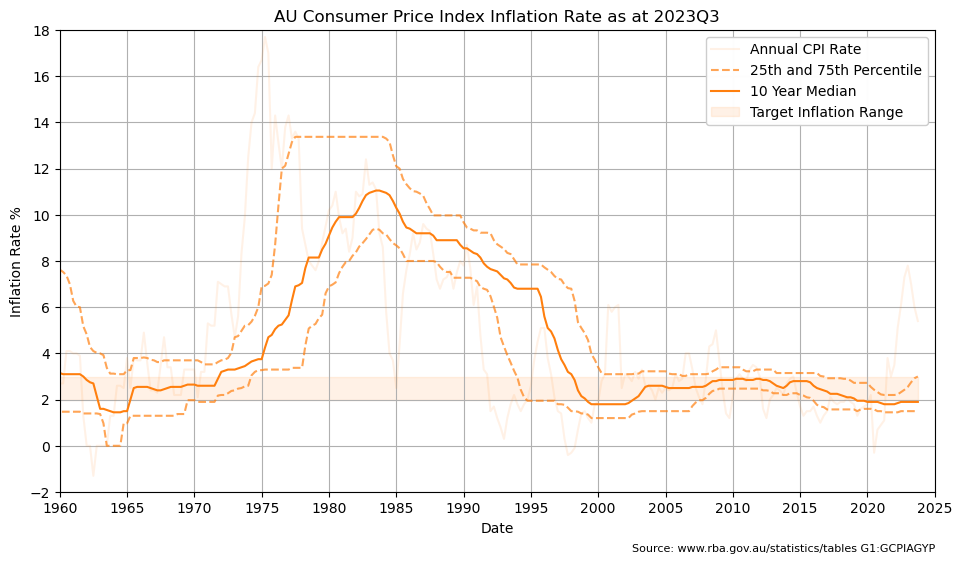

In [298]:
plot_percentiles(df_inflation, percentiles, multi_year)

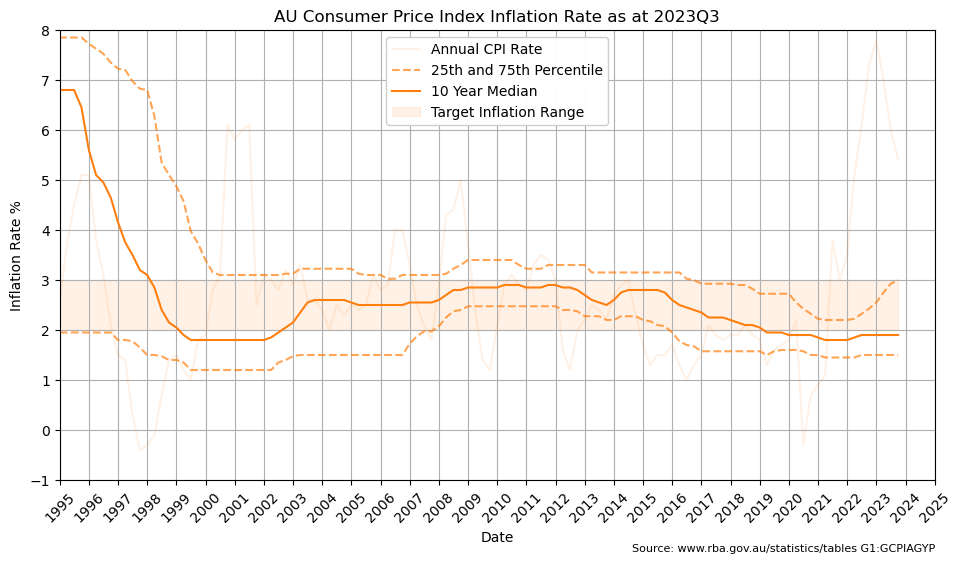

In [299]:
""" Change chart variables to plot from 1995"""
left_limit = pd.to_datetime('1995-01-01')
tick_years = 1
y_ticks = 1
top_limit = 8
bottom_limit = -1
legend_location = 'upper center'
plot_percentiles(df_inflation, percentiles, multi_year)

> ℹ The data suggests reasonable confidence using a baseline inflation of 2% to 2.5% with some uncertainty or risk that inflation could peak higher.

In [300]:
%%capture
# Magic store dataframe to share with combo notebook
%store df_inflation